###Import

In [ ]:
!pip install -U albumentations>=0.3.0 --user
!pip install -U --pre segmentation-models --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip show segmentation_models

Name: segmentation-models
Version: 1.0.1
Summary: Image segmentation models with pre-trained backbones with Keras.
Home-page: https://github.com/qubvel/segmentation_models
Author: Pavel Yakubovskiy
Author-email: qubvel@gmail.com
License: MIT
Location: /root/.local/lib/python3.10/site-packages
Requires: efficientnet, image-classifiers, keras-applications
Required-by: 


In [ ]:
import sys
sys.path.append('/root/.local/lib/python3.10/site-packages')
import os
os.environ['SM_FRAMEWORK']='tf.keras'
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

###Download dataset
CamVid Image Segmentation dataset. 360x480 RGB street scenes images.

In [ ]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

###Utility functions
    

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def plot_training_curves(history):
    """
    Plots the training and validation curves for loss, IoU score, and F1-score from a Keras History object.

    Parameters:
    history (History): The History object returned by the fit method of a Keras model.
    """

    # Extract training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract training and validation IoU score values
    iou_score = history.history['iou_score']
    val_iou_score = history.history['val_iou_score']

    # Extract training and validation F1-score values
    f1_score = history.history['f1-score']
    val_f1_score = history.history['val_f1-score']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, iou_score, 'bo-', label='Training IoU Score')
    plt.plot(epochs, val_iou_score, 'ro-', label='Validation IoU Score')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()

    # Plot training and validation F1-score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_score, 'bo-', label='Training F1-Score')
    plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_colormap(image, gt_mask, pr_mask, num_classes):
    """Plot image and masks with a colormap."""
    colormap = ListedColormap(plt.cm.get_cmap('tab10').colors[:num_classes])

    # Combine masks into a single image using the class index with the highest probability
    gt_combined = np.argmax(gt_mask, axis=-1)
    pr_combined = np.argmax(pr_mask, axis=-1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Ground Truth Mask')
    plt.imshow(gt_combined, cmap=colormap, vmin=0, vmax=num_classes-1)

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Mask')
    plt.imshow(pr_combined, cmap=colormap, vmin=0, vmax=num_classes-1)

    plt.show()

### Dataset definition

In [ ]:
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


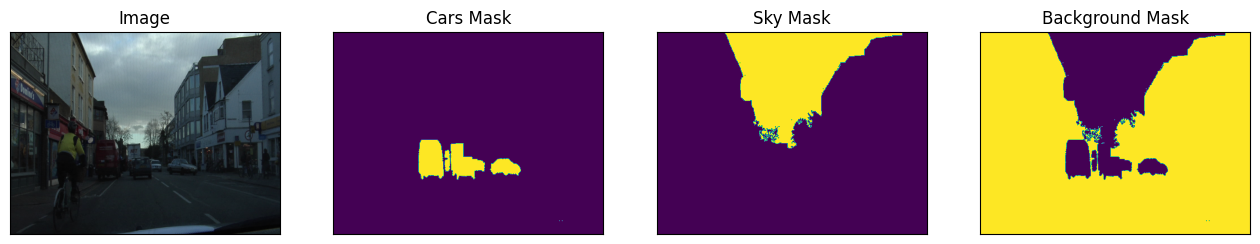

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'])

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

####Data Loader

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

###Augmentation and preprocessing

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(heigth=320, width=320):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=heigth, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=heigth, width=width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_PSP_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(min_height=384, min_width=384),
        A.CenterCrop(384, 384)
    ]
    return A.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

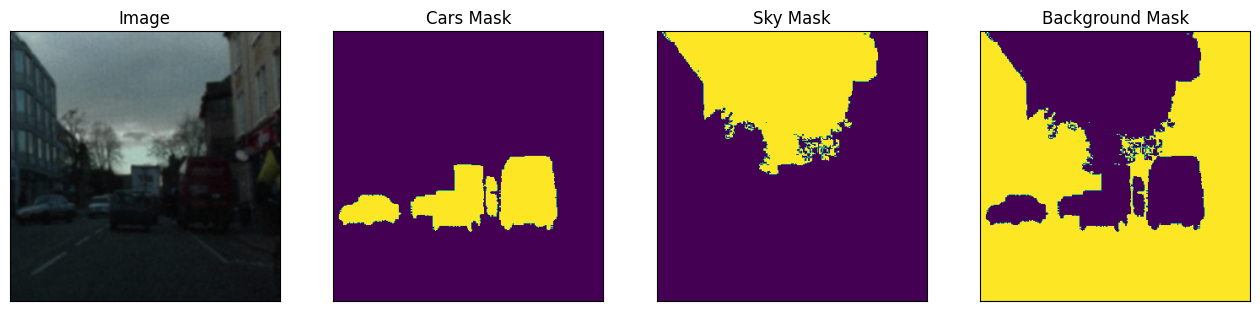

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'],
                  augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

###UNET

To simplify the taks we will consider only the following classes which maninly represents road users. The only exception is the sky class which is kept to avoid to loose the sense of the scene. Buildings, trees, fences, sygnsimbols, poles and unlabelled elements are all considered backgorund. This is a huge semplification of the semantic segmentation model.

In [ ]:
CLASSES = ['sky', 'road', 'pavement', 'car',
               'pedestrian', 'bicyclist']
num_classes = len(CLASSES) + 1

In [ ]:
# Get trainig parameters to train models

def getTrainingParameters():
  # Loss
  focal_loss = sm.losses.BinaryFocalLoss()
  dice_loss = sm.losses.DiceLoss()
  total_loss = dice_loss + (1 * focal_loss)

  # Metrics
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  return total_loss, metrics, optimizer

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
def UnetTrain(backbone):

  loss, metrics, optimizer = getTrainingParameters()

  ### Initialize model with backbone, num_classs and activation
  model = sm.Unet(backbone, classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10),
             tf.keras.callbacks.ModelCheckpoint(os.path.join('./', backbone+'_unet.h5'),
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau()]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # Create dataset with data augmentation and preprocessing normalization
  preprocess_input = sm.get_preprocessing(backbone)
  train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,
                          augmentation=get_training_augmentation(),
                          preprocessing=get_preprocessing(preprocess_input))
  val_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES,
                        augmentation=get_validation_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

  # Create dataloader
  train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
  valid_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)
  # check shapes for errors
  assert train_dataloader[0][0].shape == (8, 320, 320, 3)
  assert train_dataloader[0][1].shape == (8, 320, 320, num_classes)
  # check shapes for errors
  assert valid_dataloader[0][0].shape == (1, 384, 480, 3)
  assert valid_dataloader[0][1].shape == (1, 384, 480, num_classes)

  # Fit the model
  history = model.fit_generator(
      train_dataloader,
      steps_per_epoch=len(train_dataloader),
      epochs=40,
      callbacks=callbacks,
      validation_data=valid_dataloader,
      validation_steps=len(valid_dataloader),
  )

  val_scores = model.evaluate_generator(valid_dataloader)

  return model, history, val_scores

####Densenet121

In [ ]:
densenet_unet, history, val_scores = UnetTrain('densenet121')

29084464/29084464 [==============================] - 0s 0us/step


<ipython-input-16-0fa9d57c1f97>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
45/45 [==============================] - 108s 592ms/step - loss: 0.8847 - iou_score: 0.0659 - f1-score: 0.0964 - val_loss: 0.8844 - val_iou_score: 0.0777 - val_f1-score: 0.1205 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 24s 528ms/step - loss: 0.7224 - iou_score: 0.2087 - f1-score: 0.2528 - val_loss: 0.7597 - val_iou_score: 0.2006 - val_f1-score: 0.2418 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 24s 531ms/step - loss: 0.6195 - iou_score: 0.4537 - f1-score: 0.5354 - val_loss: 0.6565 - val_iou_score: 0.4919 - val_f1-score: 0.5649 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 24s 531ms/step - loss: 0.5553 - iou_score: 0.5293 - f1-score: 0.6009 - val_loss: 0.6022 - val_iou_score: 0.5237 - val_f1-score: 0.5829 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 24s 527ms/step - loss: 0.5127 - iou_score: 0.5497 - f1-score: 0.6158 - val_loss: 0.5301 - val_iou_score: 0.5586 - val_f1-score: 0.6

<ipython-input-16-0fa9d57c1f97>:46: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


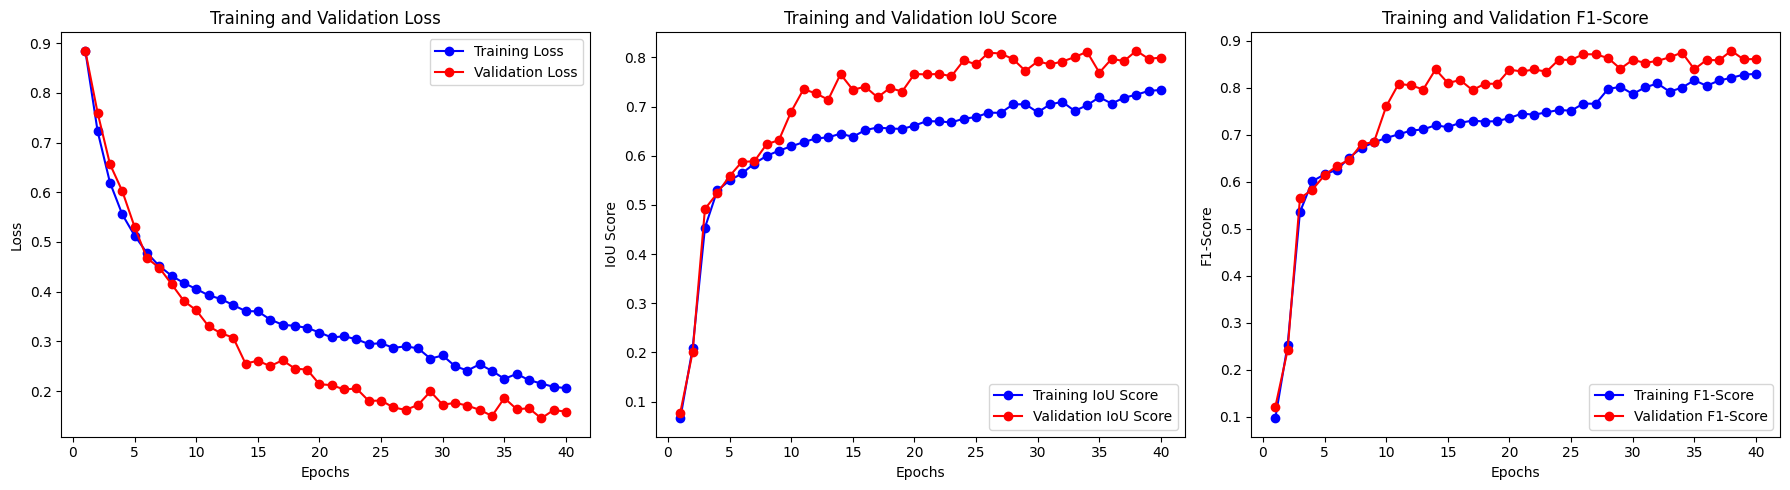

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.15832
mean iou_score: 0.79962
mean f1-score: 0.86142


####ResNet101

In [ ]:
resnet_unet, history, val_scores = UnetTrain('resnet101')

171164896/171164896 [==============================] - 1s 0us/step


<ipython-input-16-0fa9d57c1f97>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
45/45 [==============================] - 83s 564ms/step - loss: 0.8257 - iou_score: 0.1494 - f1-score: 0.2010 - val_loss: 0.8129 - val_iou_score: 0.0693 - val_f1-score: 0.1097 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 23s 511ms/step - loss: 0.6886 - iou_score: 0.3445 - f1-score: 0.4121 - val_loss: 0.7239 - val_iou_score: 0.3146 - val_f1-score: 0.3822 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 23s 512ms/step - loss: 0.6062 - iou_score: 0.4298 - f1-score: 0.4889 - val_loss: 0.6343 - val_iou_score: 0.4555 - val_f1-score: 0.4984 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 23s 518ms/step - loss: 0.5406 - iou_score: 0.5188 - f1-score: 0.5884 - val_loss: 0.5483 - val_iou_score: 0.5466 - val_f1-score: 0.6042 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 23s 504ms/step - loss: 0.5037 - iou_score: 0.5333 - f1-score: 0.6034 - val_loss: 0.4850 - val_iou_score: 0.5748 - val_f1-score: 0.63

<ipython-input-16-0fa9d57c1f97>:46: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


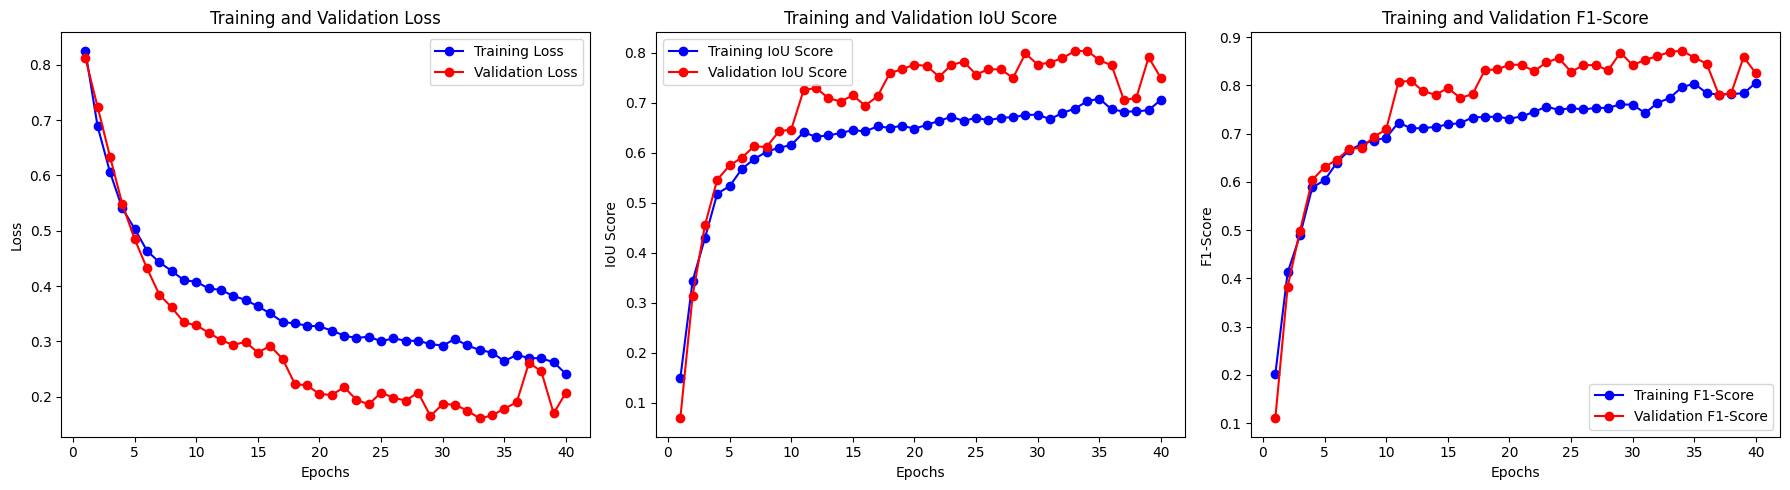

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.20726
mean iou_score: 0.74939
mean f1-score: 0.82479


###PSPNet

In [ ]:
def PSPnetTrain(backbone):

  loss, metrics, optimizer = getTrainingParameters()

  ### Initialize model with backbone, num_classs and activation
  model = sm.PSPNet(backbone, classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10),
             tf.keras.callbacks.ModelCheckpoint(os.path.join('./',backbone+'_pspnet.h5'),
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau()]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # Create dataset with data augmentation and preprocessing normalization
  preprocess_input = sm.get_preprocessing(backbone)
  train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,
                          augmentation=get_training_augmentation(heigth=384,
                                                                 width=384),
                          preprocessing=get_preprocessing(preprocess_input))
  val_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES,
                        augmentation=get_PSP_validation_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

  # Create dataloader
  train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
  valid_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)
  # check shapes for errors
  assert train_dataloader[0][0].shape == (8, 384, 384, 3)
  assert train_dataloader[0][1].shape == (8, 384, 384, num_classes)
  # check shapes for errors
  assert valid_dataloader[0][0].shape == (1, 384, 384, 3)
  assert valid_dataloader[0][1].shape == (1, 384, 384, num_classes)

  # Fit the model
  history = model.fit_generator(
      train_dataloader,
      steps_per_epoch=len(train_dataloader),
      epochs=40,
      callbacks=callbacks,
      validation_data=valid_dataloader,
      validation_steps=len(valid_dataloader),
  )

  val_scores = model.evaluate_generator(valid_dataloader)

  return model, history, val_scores

####Densenet121

In [ ]:
densenet_psp, history, val_scores = PSPnetTrain('densenet121')

29084464/29084464 [==============================] - 0s 0us/step


<ipython-input-16-abed8d0fd57b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
45/45 [==============================] - 56s 544ms/step - loss: 0.6780 - iou_score: 0.3141 - f1-score: 0.3964 - val_loss: 0.8479 - val_iou_score: 0.0014 - val_f1-score: 0.0014 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 24s 526ms/step - loss: 0.5337 - iou_score: 0.4477 - f1-score: 0.5352 - val_loss: 0.7508 - val_iou_score: 0.1420 - val_f1-score: 0.1992 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 24s 541ms/step - loss: 0.4959 - iou_score: 0.4819 - f1-score: 0.5634 - val_loss: 0.6420 - val_iou_score: 0.3416 - val_f1-score: 0.3973 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 24s 531ms/step - loss: 0.4615 - iou_score: 0.5151 - f1-score: 0.5903 - val_loss: 0.5314 - val_iou_score: 0.5010 - val_f1-score: 0.5795 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 24s 535ms/step - loss: 0.4386 - iou_score: 0.5370 - f1-score: 0.6094 - val_loss: 0.4570 - val_iou_score: 0.5651 - val_f1-score: 0.63

<ipython-input-16-abed8d0fd57b>:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


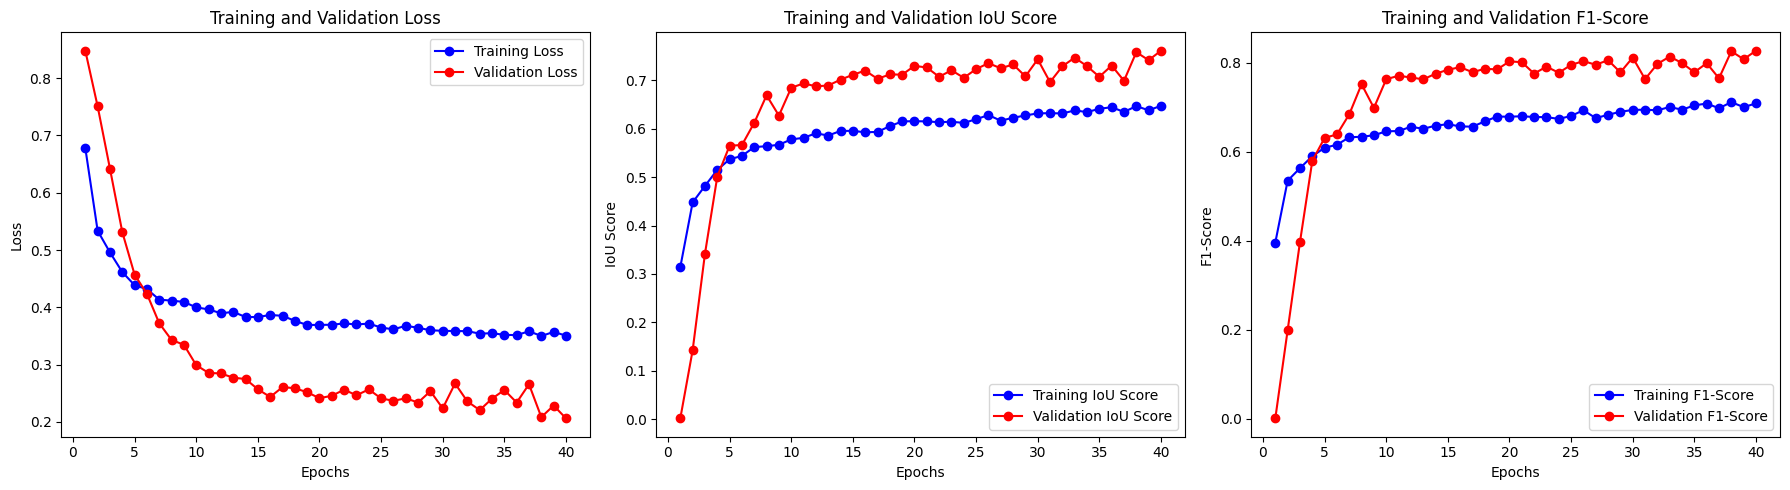

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.20622
mean iou_score: 0.7614
mean f1-score: 0.82729


####ResNet101

In [ ]:
resnet_psp, history, val_scores = PSPnetTrain('resnet101')

171164896/171164896 [==============================] - 1s 0us/step


<ipython-input-16-abed8d0fd57b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
45/45 [==============================] - 40s 526ms/step - loss: 0.6870 - iou_score: 0.2982 - f1-score: 0.3781 - val_loss: 0.9136 - val_iou_score: 0.0014 - val_f1-score: 0.0014 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 23s 518ms/step - loss: 0.5620 - iou_score: 0.4215 - f1-score: 0.5106 - val_loss: 0.8764 - val_iou_score: 0.0014 - val_f1-score: 0.0014 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 24s 523ms/step - loss: 0.5193 - iou_score: 0.4573 - f1-score: 0.5421 - val_loss: 0.8278 - val_iou_score: 0.0016 - val_f1-score: 0.0018 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 23s 515ms/step - loss: 0.4924 - iou_score: 0.4838 - f1-score: 0.5646 - val_loss: 0.7819 - val_iou_score: 0.0589 - val_f1-score: 0.0931 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 23s 519ms/step - loss: 0.4726 - iou_score: 0.5016 - f1-score: 0.5788 - val_loss: 0.7512 - val_iou_score: 0.0969 - val_f1-score: 0.14

<ipython-input-16-abed8d0fd57b>:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


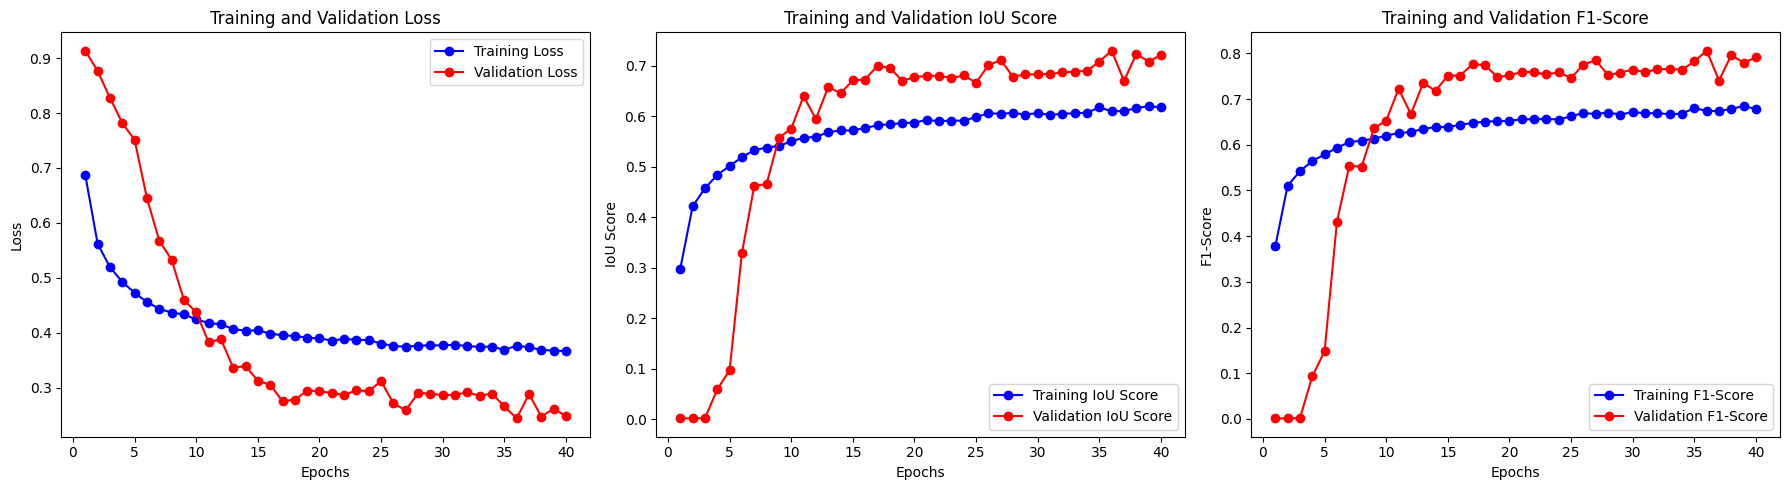

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.24814
mean iou_score: 0.7215
mean f1-score: 0.79111


###FPN

In [ ]:
def FPNTrain(backbone):

  loss, metrics, optimizer = getTrainingParameters()

  ### Initialize model with backbone, num_classs and activation
  model = sm.FPN(backbone, classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10),
             tf.keras.callbacks.ModelCheckpoint(os.path.join('./',backbone+'_fpnet.h5'),
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau()]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # Create dataset with data augmentation and preprocessing normalization
  preprocess_input = sm.get_preprocessing(backbone)
  train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,
                          augmentation=get_training_augmentation(),
                          preprocessing=get_preprocessing(preprocess_input))
  val_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES,
                        augmentation=get_validation_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

  # Create dataloader
  train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
  valid_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)
  # check shapes for errors
  assert train_dataloader[0][0].shape == (8, 320, 320, 3)
  assert train_dataloader[0][1].shape == (8, 320, 320, num_classes)
  # check shapes for errors
  assert valid_dataloader[0][0].shape == (1, 384, 480, 3)
  assert valid_dataloader[0][1].shape == (1, 384, 480, num_classes)

  # Fit the model
  history = model.fit_generator(
      train_dataloader,
      steps_per_epoch=len(train_dataloader),
      epochs=40,
      callbacks=callbacks,
      validation_data=valid_dataloader,
      validation_steps=len(valid_dataloader),
  )

  val_scores = model.evaluate_generator(valid_dataloader)

  return model, history, val_scores

####Densenet121

In [ ]:
densenet_fpn, history, val_scores = FPNTrain('densenet121')

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

Epoch 1/40
45/45 [==============================] - 114s 593ms/step - loss: 0.5975 - iou_score: 0.3808 - f1-score: 0.4610 - val_loss: 0.5760 - val_iou_score: 0.4039 - val_f1-score: 0.4769 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 23s 514ms/step - loss: 0.4630 - iou_score: 0.5109 - f1-score: 0.5937 - val_loss: 0.4618 - val_iou_score: 0.5002 - val_f1-score: 0.5837 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 23s 509ms/step - loss: 0.4242 - iou_score: 0.5534 - f1-score: 0.6362 - val_loss: 0.3536 - val_iou_score: 0.6338 - val_f1-score: 0.7285 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 23s 512ms/step - loss: 0.4029 - iou_score: 0.5748 - f1-score: 0.6631 - val_loss: 0.3112 - val_iou_score: 0.6671 - val_f1-score: 0.7573 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 23s 507ms/step - loss: 0.3704 - iou_score: 0.5940 - f1-score: 0.6850 - val_loss: 0.3391 - val_iou_score: 0.6364 - val_f1-score: 0.7

<ipython-input-22-0c6590b3b5dc>:46: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


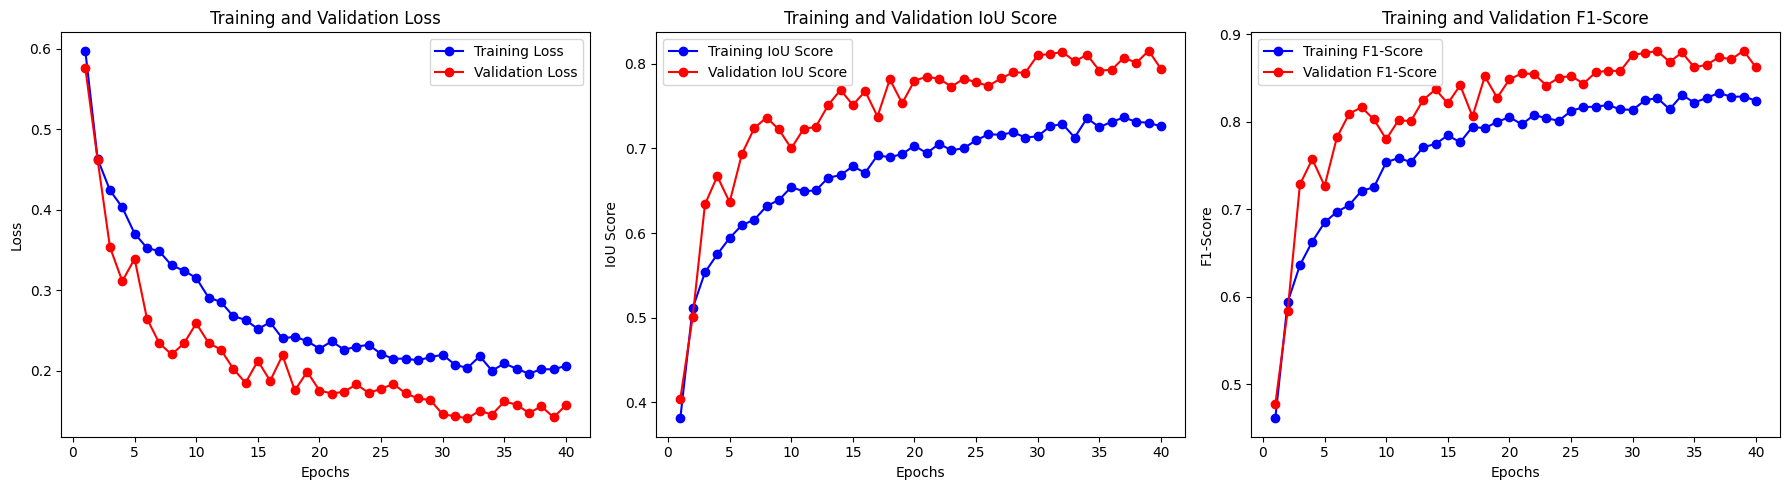

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.15488
mean iou_score: 0.79915
mean f1-score: 0.86755


####ResNet101

In [ ]:
resnet_fpn, history, val_scores = FPNTrain('resnet101')

171164896/171164896 [==============================] - 1s 0us/step


<ipython-input-22-0c6590b3b5dc>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
45/45 [==============================] - 80s 543ms/step - loss: 0.5874 - iou_score: 0.3954 - f1-score: 0.4823 - val_loss: 0.5661 - val_iou_score: 0.4727 - val_f1-score: 0.5457 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 23s 509ms/step - loss: 0.4529 - iou_score: 0.5193 - f1-score: 0.6086 - val_loss: 0.4690 - val_iou_score: 0.5126 - val_f1-score: 0.5881 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 23s 510ms/step - loss: 0.4112 - iou_score: 0.5555 - f1-score: 0.6455 - val_loss: 0.4140 - val_iou_score: 0.5603 - val_f1-score: 0.6403 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 24s 519ms/step - loss: 0.3868 - iou_score: 0.5765 - f1-score: 0.6664 - val_loss: 0.3609 - val_iou_score: 0.6229 - val_f1-score: 0.7202 - lr: 1.0000e-04
Epoch 5/40
30/45 [===================>..........] - ETA: 6s - loss: 0.3663 - iou_score: 0.5983 - f1-score: 0.6853

KeyboardInterrupt: 

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.15062
mean iou_score: 0.8042
mean f1-score: 0.87135


In [ ]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('densenet121'))
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Load a model to evaluate. Define and compile with getTrainingParamters.
# Load saved weights
model = densenet_fpn

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

<ipython-input-37-085d0e8f0f9f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.33628
mean iou_score: 0.73348
mean f1-score: 0.80181


###DenseASPP

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, Activation, Input, MaxPool2D, ZeroPadding2D, SpatialDropout2D, MaxPool2D, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121, ResNet50,VGG16

####Building Blocks

In [ ]:
# Questo blocco fa da ponte con il base model. I parametri vanno settati di
# conseguenza.
def FirstConvolution(X, input_feature):
  num_init_features = input_feature
  X = ZeroPadding2D(padding=2)(X)
  X = Conv2D(filters = num_init_features, kernel_size=7, strides=2, use_bias=False)(X)
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
  return X

In [ ]:
def DenseAsppBlock(X, num1, num2, dilation_rate, dropout,
                   bn_first=True):
  if bn_first:
    X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters=num1, kernel_size=1)(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = ZeroPadding2D(padding=dilation_rate)(X)
  X = Conv2D(filters=num2, kernel_size=3, dilation_rate=dilation_rate)(X)
  if dropout > 0:
    X = SpatialDropout2D(rate=dropout)(X)
  return X

In [ ]:
def Classification(X, dropout, num_class):
  X = SpatialDropout2D(rate=dropout)(X)
  X = Conv2D(filters=num_class, kernel_size=1, padding='valid', activation='sigmoid')(X)
  X = UpSampling2D(size=(32,32), interpolation='bilinear')(X)
  return X

####Top Model

In [ ]:
def DenseAspp(num_classes, short=False, input_feature=512):

  X_input = Input((None, None, input_feature))
  X = X_input
  X = FirstConvolution(X, input_feature)

  # ASPP blocks
  aspp3 = DenseAsppBlock(X, input_feature/2, input_feature/8, 3, 0, False)
  X = tf.concat([aspp3, X], axis=-1)

  aspp6 = DenseAsppBlock(X, input_feature/2, input_feature/8, 6, 0, True)
  X = tf.concat([aspp6, X], axis=-1)

  aspp12 = DenseAsppBlock(X, input_feature/2, input_feature/8, 12, 0, True)
  X = tf.concat([aspp12, X], axis=-1)

  aspp18 = DenseAsppBlock(X, input_feature/2, input_feature/8, 18, 0, True)
  X = tf.concat([aspp18, X], axis=-1)

  if  not(short):
    aspp24 = DenseAsppBlock(X, input_feature/2, input_feature/8, 24, 0, True)
    X = tf.concat([aspp24, X], axis=-1)

  #classification
  X = Classification(X, 0.2, num_classes)

  model = Model(inputs=X_input, outputs=X, name='DenseAspp')
  return model

####Full Model

In [ ]:
# Set encoder freeze to true to train only the DenseASPP module
def FullModel(num_classes, short=False, encoder_freeze=False):

  #The backbone is downloaded from Segmentation Model library
  model = sm.PSPNet('densenet121', downsample_factor=8,
                    encoder_freeze=encoder_freeze)
  intermediate_layer_name = 'pool3_relu'
  intermediate_layer = model.get_layer(intermediate_layer_name).output
  densenet121 = Model(inputs=model.input, outputs=intermediate_layer,
                      name='Densenet121')

  X_input = densenet121.input
  X = densenet121(X_input)
  dense_aspp = DenseAspp(num_classes, short=short)
  X = dense_aspp(X)
  model = Model(inputs=X_input, outputs=X, name='DenseASPP_with_backbone')

  return model


#### Training

In [ ]:
def DenseASPPTrain(num_classes, short=False, encoder_freeze=False):

  loss, metrics, optimizer = getTrainingParameters()
  model = FullModel(num_classes, encoder_freeze=encoder_freeze)

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10),
             tf.keras.callbacks.ModelCheckpoint(os.path.join('./', 'dense_aspp.h5'),
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau()]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # Create dataset with data augmentation and preprocessing normalization
  preprocess_input = sm.get_preprocessing('densenet121')
  train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,
                          augmentation=get_training_augmentation(384,384),
                          preprocessing=get_preprocessing(preprocess_input))
  val_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES,
                        augmentation=get_PSP_validation_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

  # Create dataloader
  train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
  valid_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)
  # check shapes for errors
  assert train_dataloader[0][0].shape == (8, 384, 384, 3)
  assert train_dataloader[0][1].shape == (8, 384, 384, num_classes)
  # check shapes for errors
  assert valid_dataloader[0][0].shape == (1, 384, 384, 3)
  assert valid_dataloader[0][1].shape == (1, 384, 384, num_classes)

  # Fit the model
  history = model.fit_generator(
      train_dataloader,
      steps_per_epoch=len(train_dataloader),
      epochs=40,
      callbacks=callbacks,
      validation_data=valid_dataloader,
      validation_steps=len(valid_dataloader),
  )

  val_scores = model.evaluate_generator(valid_dataloader)

  return model, history, val_scores

In [ ]:
dense_aspp, history, val_scores = DenseASPPTrain(num_classes, encoder_freeze=True)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

Epoch 1/40
45/45 [==============================] - 42s 545ms/step - loss: 0.6556 - iou_score: 0.3541 - f1-score: 0.4366 - val_loss: 0.7322 - val_iou_score: 0.1909 - val_f1-score: 0.2459 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 24s 541ms/step - loss: 0.5232 - iou_score: 0.4606 - f1-score: 0.5547 - val_loss: 0.6419 - val_iou_score: 0.3514 - val_f1-score: 0.3860 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 25s 544ms/step - loss: 0.4832 - iou_score: 0.4953 - f1-score: 0.5963 - val_loss: 0.5972 - val_iou_score: 0.4003 - val_f1-score: 0.4392 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 24s 530ms/step - loss: 0.4526 - iou_score: 0.5189 - f1-score: 0.6290 - val_loss: 0.5673 - val_iou_score: 0.4169 - val_f1-score: 0.4593 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 25s 542ms/step - loss: 0.4492 - iou_score: 0.5180 - f1-score: 0.6290 - val_loss: 0.5226 - val_iou_score: 0.4438 - val_f1-score: 0.49

<ipython-input-28-3d93f3618131>:44: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_scores = model.evaluate_generator(valid_dataloader)


In [ ]:
dense_aspp.summary()

Model: "DenseASPP_with_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 Densenet121 (Functional)    (None, 48, 48, 512)       1313856   
                                                                 
 DenseAspp (Functional)      (None, None, None, 7)     14424839  
                                                                 
Total params: 15738695 (60.04 MB)
Trainable params: 14432199 (55.05 MB)
Non-trainable params: 1306496 (4.98 MB)
_________________________________________________________________


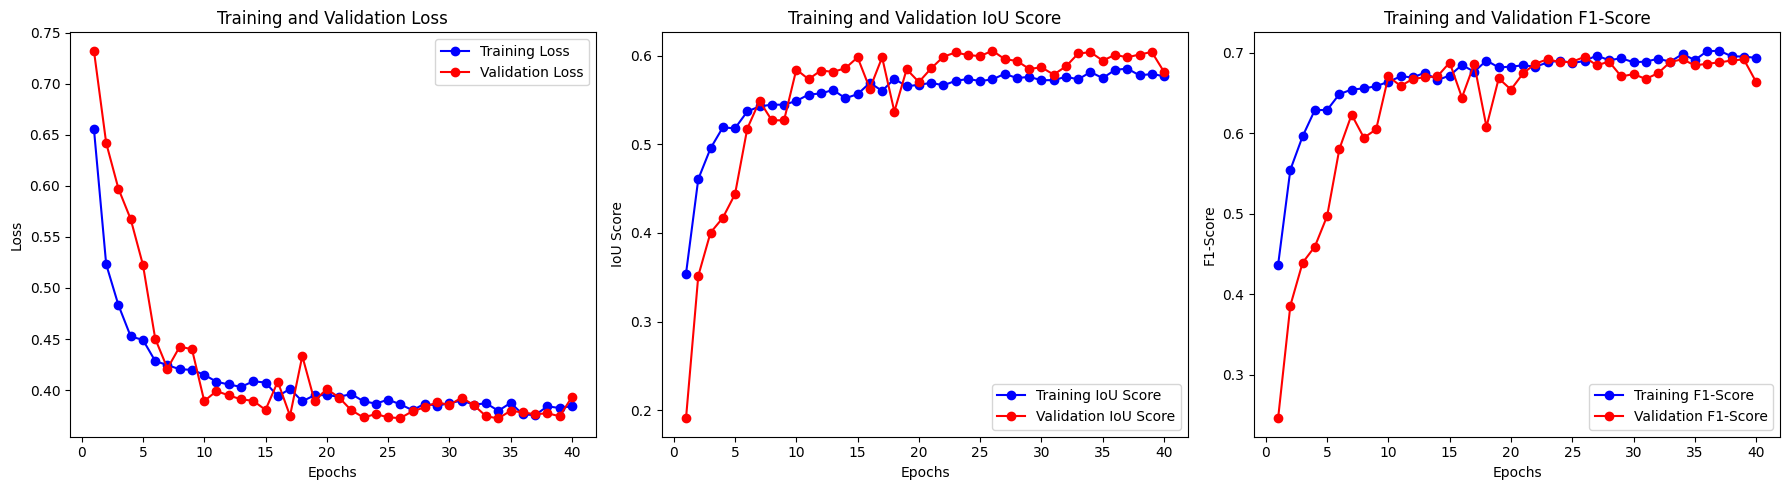

In [ ]:
plot_training_curves(history)

In [ ]:
print("Loss: {:.5}".format(val_scores[0]))
for metric, value in zip(metrics, val_scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.39327
mean iou_score: 0.5816
mean f1-score: 0.66386


###Test evaluation
The best model on the validation set is the FPNnet with the ResNet101 backbone. Ww will now assess its performance on the test split.

In [ ]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('resnet101'))
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Load a model to evaluate. Define and compile with getTrainingParamters.
# Load saved weights
loss, metrics, optimizer = getTrainingParameters()
model = sm.FPN('resnet101', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

171164896/171164896 [==============================] - 1s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/end_to_end/FPNnet'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/end_to_end/FPNnet


In [ ]:
model.load_weights('resnet101_fpnet.h5')

In [ ]:
cd '/content'

/content


In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

<ipython-input-25-085d0e8f0f9f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.32689
mean iou_score: 0.73449
mean f1-score: 0.79915


The value of the mean IoU score dropped from around 0.8 to 0.73. The F1-score decreased as well, from 0.87 down to almost 0.8. This is coherent with the result found for the MaskFormer model (even if it was trained on all the classes) and higglights the higher complexity of the test set with respect to the validation set.

####Visualization
Visualization of some predicted mask from the best model found.

1/1 [==============================] - 2s 2s/step


<ipython-input-7-c383e320d8f4>:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = ListedColormap(plt.cm.get_cmap('tab10').colors[:num_classes])


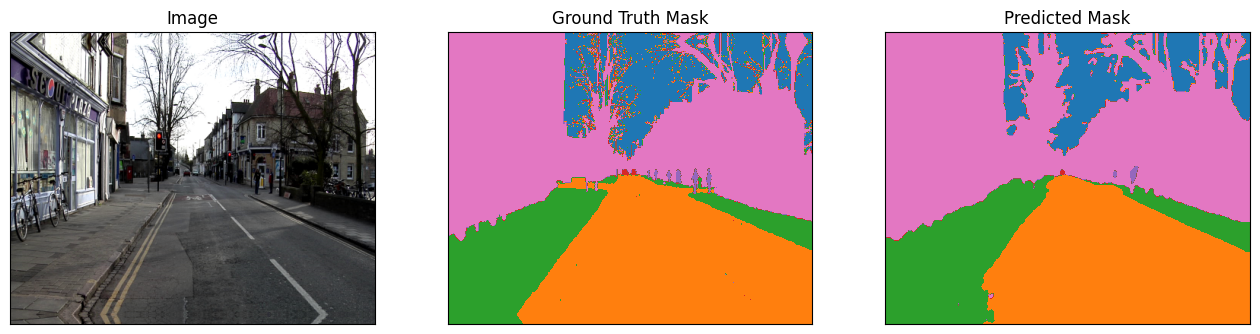

1/1 [==============================] - 1s 981ms/step


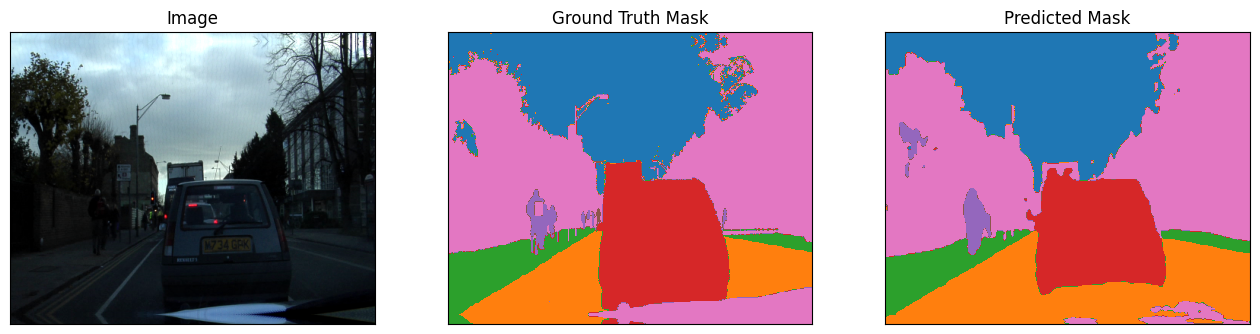

1/1 [==============================] - 1s 979ms/step


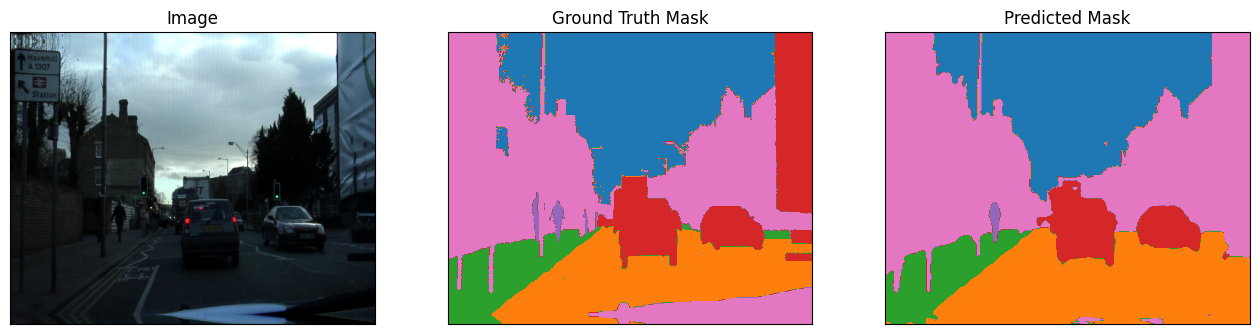

1/1 [==============================] - 1s 900ms/step


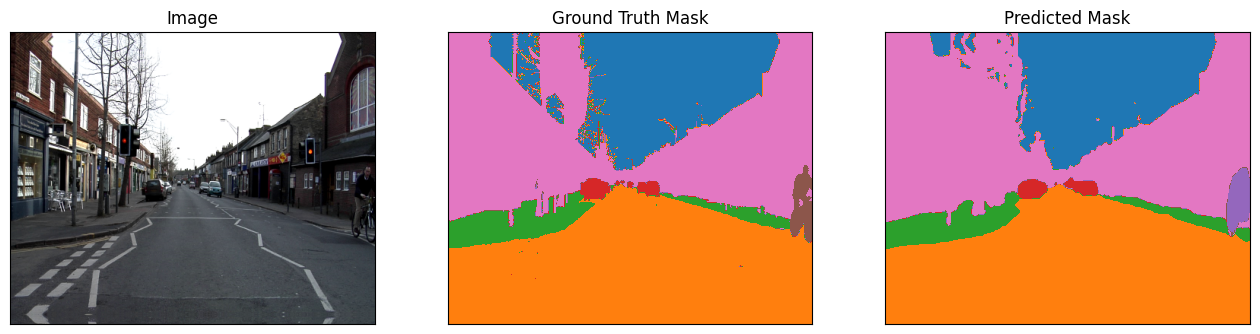

1/1 [==============================] - 1s 882ms/step


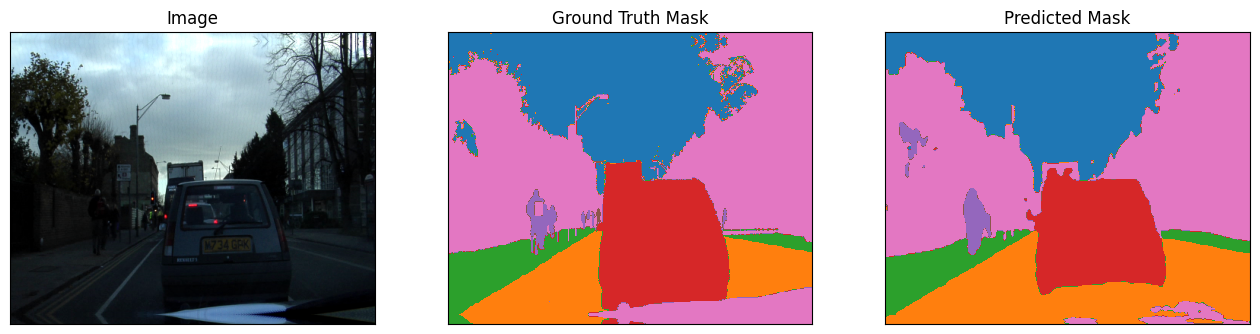

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)

    visualize_colormap(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
        num_classes=pr_mask.shape[-1]
    )
